In [ ]:
# Install the necessary libraries
!pip install jupyter pandas matplotlib opencv-python-headless
!pip install keras
!pip install --upgrade tensorflow

In [1]:
!pip install gdown

# to upgrade
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from itertools import combinations
from tqdm import tqdm
import os
import gdown
from sklearn.cluster import DBSCAN
import gc
from tensorflow.keras import layers, models
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:

import gdown

url = "https://drive.google.com/file/d/1xGBYnRgJkYVBnnQpTphWkmEyU77etqPd/view?usp=sharing"  # Direct link to the file
output = "/content/GTSDB.zip"
gdown.download(url=url, output=output, fuzzy=True)

# Unzip the downloaded file
import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Adjust the path to where you've extracted the gt.txt file and images in Colab
gt_path = '/content/GTSDB/FullIJCNN2013/gt.txt'
images_path = Path('/content/GTSDB/FullIJCNN2013/FullIJCNN2013')
output_path = Path('/content/ProcessedImages')
augmented_path = Path('/content/AugmentedImages')

output_path.mkdir(parents=True, exist_ok=True)
augmented_path.mkdir(parents=True, exist_ok=True)

# Load the ground truth file
columns = ['Filename', 'LeftCol', 'TopRow', 'RightCol', 'BottomRow', 'ClassID']
gt_data = pd.read_csv(gt_path, sep=';', header=None, names=columns)

# Display the first few rows of the dataframe
print(gt_data.head())

Downloading...
From (original): https://drive.google.com/uc?id=1xGBYnRgJkYVBnnQpTphWkmEyU77etqPd
From (redirected): https://drive.google.com/uc?id=1xGBYnRgJkYVBnnQpTphWkmEyU77etqPd&confirm=t&uuid=927837d4-c5b1-43d8-842e-bbe08fa21ebb
To: /content/GTSDB.zip
100%|██████████| 1.72G/1.72G [00:26<00:00, 66.0MB/s]


    Filename  LeftCol  TopRow  RightCol  BottomRow  ClassID
0  00000.ppm      774     411       815        446       11
1  00001.ppm      983     388      1024        432       40
2  00001.ppm      386     494       442        552       38
3  00001.ppm      973     335      1031        390       13
4  00002.ppm      892     476      1006        592       39


In [4]:

# Enhanced data augmentation
data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Load the ground truth file
gt_path = '/content/GTSDB/FullIJCNN2013/gt.txt'
images_path = Path('/content/GTSDB/FullIJCNN2013/FullIJCNN2013')
columns = ['Filename', 'LeftCol', 'TopRow', 'RightCol', 'BottomRow', 'ClassID']
gt_data = pd.read_csv(gt_path, sep=';', header=None, names=columns)

# Split the data into training, validation, and test sets
train_data, temp_data = train_test_split(gt_data, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Save the data splits
train_data.to_csv('/content/train_data.csv', index=False)
validation_data.to_csv('/content/validation_data.csv', index=False)
test_data.to_csv('/content/test_data.csv', index=False)

In [5]:
# Preprocessing function
def preprocess_image_v2(image_path, bounding_boxes, image_size=(512, 512)):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    image = cv2.resize(image, (image_size[1], image_size[0]))

    mask = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)
    for bbox in bounding_boxes:
        left, top, right, bottom = bbox
        left = int(left * image_size[1] / original_size[1])
        top = int(top * image_size[0] / original_size[0])
        right = int(right * image_size[1] / original_size[1])
        bottom = int(bottom * image_size[0] / original_size[0])
        cv2.rectangle(mask, (left, top), (right, bottom), 1, -1)

    return image, mask

def data_generator_v2(gt_data, images_path, batch_size, image_size=(512, 512), augment=False):
    while True:
        batch_images = []
        batch_masks = []

        for i in range(batch_size):
            random_index = np.random.randint(0, len(gt_data))
            row = gt_data.iloc[random_index]
            image_path = images_path / row['Filename']
            bounding_boxes = [(row['LeftCol'], row['TopRow'], row['RightCol'], row['BottomRow'])]
            image, mask = preprocess_image_v2(image_path, bounding_boxes, image_size)

            if augment:
                seed = np.random.randint(1e6)
                image = image_datagen.random_transform(image, seed=seed)

                # Expand the mask to 3 channels for augmentation
                mask = np.expand_dims(mask, axis=-1)
                mask = np.repeat(mask, 3, axis=-1)
                mask = mask_datagen.random_transform(mask, seed=seed)
                # Reduce the mask back to 1 channel
                mask = mask[..., 0]

            batch_images.append(image)
            batch_masks.append(mask)

        batch_images = np.array(batch_images) / 255.0
        batch_masks = np.array(batch_masks, dtype='float32')[..., np.newaxis]

        yield batch_images, batch_masks

def validation_data_generator_v2(gt_data, images_path, batch_size, image_size=(512, 512)):
    while True:
        batch_images = []
        batch_masks = []

        for i in range(batch_size):
            random_index = np.random.randint(0, len(gt_data))
            row = gt_data.iloc[random_index]
            image_path = images_path / row['Filename']
            bounding_boxes = [(row['LeftCol'], row['TopRow'], row['RightCol'], row['BottomRow'])]
            image, mask = preprocess_image_v2(image_path, bounding_boxes, image_size)

            batch_images.append(image)
            batch_masks.append(mask)

        batch_images = np.array(batch_images) / 255.0
        batch_masks = np.array(batch_masks, dtype='float32')[..., np.newaxis]

        yield batch_images, batch_masks

# Define the IoU metric function with the smooth variable
def iou_metric_v2(y_true, y_pred, smooth=1):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef_v2(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def weighted_binary_crossentropy_v2(y_true, y_pred):
    weights = (y_true * 2.0) + 1.0
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    weighted_bce = tf.keras.backend.mean(bce * weights)
    return weighted_bce

def combined_loss_v2(y_true, y_pred):
    return weighted_binary_crossentropy_v2(y_true, y_pred) + dice_coef_loss_v2(y_true, y_pred)

def dice_coef_loss_v2(y_true, y_pred):
    return 1 - dice_coef_v2(y_true, y_pred)

# Helper function to create convolutional blocks
def conv_block_v2(x, filters):
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def build_resunet_v2(input_shape):
    inputs = Input(shape=input_shape)

    # Load pre-trained ResNet50 model + higher level layers
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Skip connections with reduced filters
    skip1 = Conv2D(32, (1, 1))(resnet50.get_layer('conv1_relu').output)  # 256x256x32
    skip2 = Conv2D(16, (1, 1))(resnet50.get_layer('conv2_block3_out').output)  # 128x128x16

    # Bridge with reduced filters
    bridge = Conv2D(8, (1, 1))(resnet50.get_layer('conv3_block4_out').output)  # 64x64x8

    # Decoder
    d1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(bridge)
    d1 = concatenate([d1, skip2])
    d1 = conv_block_v2(d1, 16)

    d2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d1)
    d2 = concatenate([d2, skip1])
    d2 = conv_block_v2(d2, 32)

    d3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    d3 = conv_block_v2(d3, 64)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d3)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss_v2, metrics=[dice_coef_v2, iou_metric_v2])

    model.summary()
    return model

In [6]:
# Instantiate the model
input_shape_v2 = (512, 512, 3)
unet_model_v2 = build_resunet_v2(input_shape_v2)

# Define learning rate scheduler callback
reduce_lr_v2 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.00001)

# Define early stopping and model checkpoint callbacks
callbacks_v2 = [
    reduce_lr_v2,
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_model.keras', monitor='val_loss', save_best_only=True)
]

# Define the data generators
batch_size_v2 = 8
steps_per_epoch_v2 = (len(train_data) // batch_size_v2) + 1
validation_steps_v2 = (len(validation_data) // batch_size_v2) + 1

train_generator_v2 = data_generator_v2(train_data, images_path, batch_size_v2, augment=True)
validation_generator_v2 = validation_data_generator_v2(validation_data, images_path, batch_size_v2)

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [7]:

# Train the model with the callback
history_v2 = unet_model_v2.fit(train_generator_v2, steps_per_epoch=steps_per_epoch_v2, epochs=30,
                                 validation_data=validation_generator_v2, validation_steps=validation_steps_v2,
                                 callbacks=callbacks_v2)


Epoch 1/30
107/107 [==============================] - 751s 7s/step - loss: 1.5079 - dice_coef_v2: 0.0045 - iou_metric_v2: 0.0023 - val_loss: 1.6223 - val_dice_coef_v2: 0.0044 - val_iou_metric_v2: 0.0022 - lr: 1.0000e-04
Epoch 2/30
107/107 [==============================] - 736s 7s/step - loss: 1.1765 - dice_coef_v2: 0.0045 - iou_metric_v2: 0.0022 - val_loss: 1.3196 - val_dice_coef_v2: 0.0042 - val_iou_metric_v2: 0.0021 - lr: 1.0000e-04
Epoch 3/30
107/107 [==============================] - 737s 7s/step - loss: 1.1442 - dice_coef_v2: 0.0046 - iou_metric_v2: 0.0023 - val_loss: 1.1730 - val_dice_coef_v2: 0.0043 - val_iou_metric_v2: 0.0022 - lr: 1.0000e-04
Epoch 4/30
107/107 [==============================] - 737s 7s/step - loss: 1.1245 - dice_coef_v2: 0.0049 - iou_metric_v2: 0.0025 - val_loss: 1.1399 - val_dice_coef_v2: 0.0039 - val_iou_metric_v2: 0.0020 - lr: 1.0000e-04
Epoch 5/30
107/107 [==============================] - 737s 7s/step - loss: 1.1100 - dice_coef_v2: 0.0053 - iou_metric_v2

In [8]:
# Save the model
unet_model_v2.save('/content/enhanced_unet_model.keras')


In [12]:

# Evaluate the model
test_steps_v2 = (len(test_data) // batch_size_v2) + 1
test_generator_v2 = validation_data_generator_v2(test_data, images_path, batch_size_v2)
loss_v2, dice_coef_v2, iou_v2 = unet_model_v2.evaluate(test_generator_v2, steps=test_steps_v2)
print(f"Loss: {loss_v2}")
print(f"Dice Coefficient: {dice_coef_v2}")
print(f"IOU: {iou_v2}")


23/23 [==============================] - 32s 1s/step - loss: 0.4723 - dice_coef_v2: 0.5547 - iou_metric_v2: 0.3969
Loss: 0.47231751680374146
Dice Coefficient: 0.5547106266021729
IOU: 0.39694803953170776


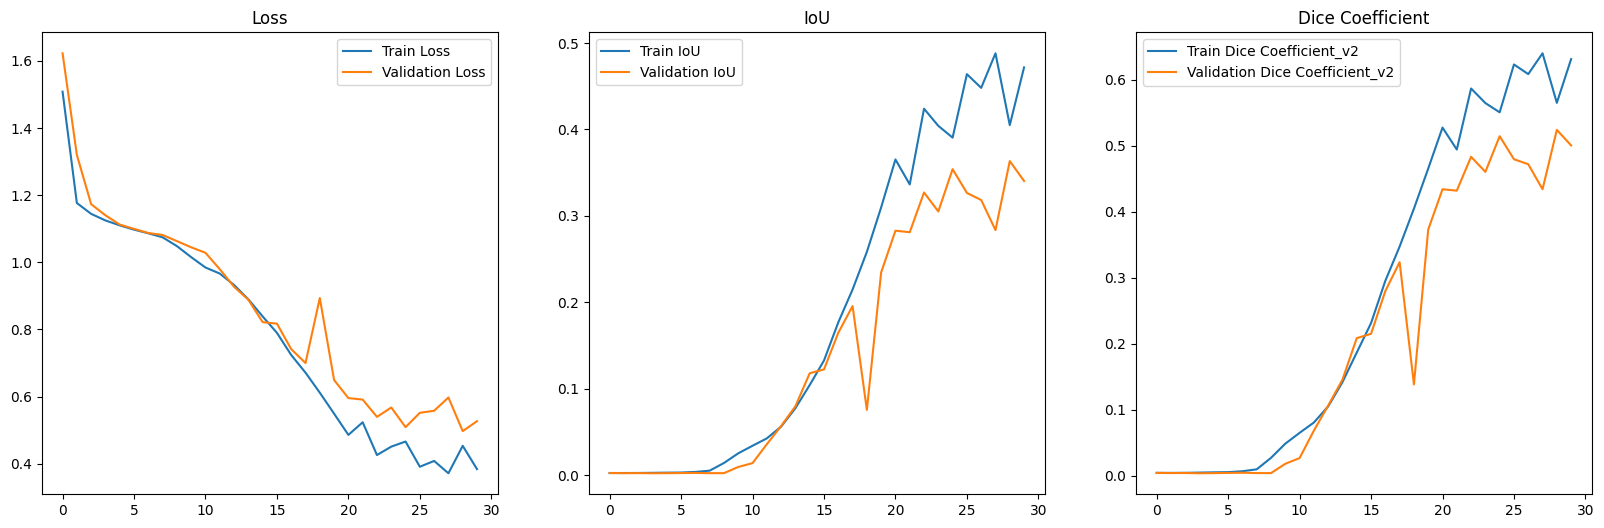

In [15]:

# Function to plot training and validation metrics
def plot_metrics_v2(history):
    plt.figure(figsize=(20, 6))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    # Plot IoU
    plt.subplot(1, 3, 2)
    plt.plot(history.history['iou_metric_v2'], label='Train IoU')
    plt.plot(history.history['val_iou_metric_v2'], label='Validation IoU')
    plt.legend()
    plt.title('IoU')

    # Plot Dice Coefficient
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coef_v2'], label='Train Dice Coefficient_v2')
    plt.plot(history.history['val_dice_coef_v2'], label='Validation Dice Coefficient_v2')
    plt.legend()
    plt.title('Dice Coefficient')

    plt.show()

# Plot the metrics
plot_metrics_v2(history_v2)


In [16]:

# Function to visualize predictions
def visualize_predictions_v2(generator, model, num_images=5):
    for _ in range(num_images):
        images, masks = next(generator)
        predictions = model.predict(images)

        for i in range(len(images)):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title('Original Image')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].squeeze(), cmap='gray')
            plt.title('Ground Truth')

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i].squeeze(), cmap='gray')
            plt.title('Predicted Mask')

            plt.show()

# Visualize predictions
visualize_predictions_v2(test_generator_v2, unet_model_v2)


Output hidden; open in https://colab.research.google.com to view.

In [18]:

# Freezing and saving the model
from tensorflow.keras.models import load_model

# Function to load and freeze the model
def load_and_freeze_model_v2(model_path):
    model = load_model(model_path, custom_objects={'dice_coef_v2': dice_coef_v2, 'iou_metric_v2': iou_metric_v2, 'combined_loss_v2': combined_loss_v2})
    model.trainable = False
    return model

# Load and freeze the best model
frozen_model_v2 = load_and_freeze_model_v2('/content/best_model.keras')

# Save the frozen model
frozen_model_v2.save('/content/frozen_enhanced_unet_model.keras')